In [16]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [1]:
import os
import pandas as pd
import numpy as np
import pickle as pkl

from datetime import datetime
from pathlib import Path
from factorlib.factor import Factor
from factorlib.factor_model import FactorModel
from factorlib.stats import Statistics
from factorlib.types import PortOptOptions, ModelType
from factorlib.utils.system import get_raw_data_dir, get_experiments_dir

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [5]:
INTERVAL = 'B'
DATA_FOLDER = get_raw_data_dir()
returns = pd.read_parquet(DATA_FOLDER / 'sp500_returns.parquet.brotli')
tickers = np.unique(returns['ticker']).tolist()

## Creating the Initial Model
First we will add our factors to the model, and run our wfo(). This will save the model in our save_dir, which we can then load back when adding incremental factors.

In [6]:
factor_model = FactorModel(name='base_model', tickers=tickers, interval=INTERVAL, model_type=ModelType.lightgbm)

In [7]:
factor_data = pd.read_parquet(DATA_FOLDER / 'factor_return.parquet.brotli')
factor = Factor(name='ret', interval=INTERVAL, data=factor_data, tickers=tickers)
factor_model.add_factor(factor)
del factor_data, factor

Creating factor: ret --------------------------------------- | ✔
Adding ret to base_model -----------------------------------| ✔


In [8]:
factor1_data = pd.read_parquet(DATA_FOLDER / 'factor_pca_return.parquet.brotli')
factor1 = Factor(name='pca_ret', interval=INTERVAL, data=factor1_data, tickers=tickers)
factor_model.add_factor(factor1, replace=True)
del factor1_data, factor1

Creating factor: pca_ret ----------------------------------- | ✔
Adding pca_ret to base_model ------------------------------- | ✔


In [9]:
factor2_data = pd.read_parquet(DATA_FOLDER / 'factor_fund_ratio_div_price.parquet.brotli')
factor2 = Factor(name='fund_ratio', interval=INTERVAL, data=factor2_data, tickers=tickers)
factor_model.add_factor(factor2, replace=True)
del factor2_data, factor2

Creating factor: fund_ratio -------------------------------- | ✔
Adding fund_ratio to base_model ---------------------------- | ✔


In [10]:
with open('data/raw/sp500_candidates.pkl', 'rb') as p:
    candidates = pkl.load(p)

In [11]:
kwargs = {
    'random_state': 42,
    'n_jobs': -1,
    'boosting': 'gbdt',
    'objective': 'regression',
    'verbose': -1,
    'max_depth': -1,
    'learning_rate': 0.15,
    'num_leaves': 15,
    'feature_fraction': 0.85,
    'min_gain_to_split': 0.02,
    'min_data_in_leaf_opts': 60,
    'metric': 'mse',
    'num_threads': 8,
    'lambda_l2': 0.01,
    'extra_trees': False,
    'num_boost_round': 1000
}


--------------------------------------------------------------------------------
Starting Walk-Forward Optimization (trail 6) from 2017-11-05 00:00:00 to 2022-12-20 00:00:00 with a 5 year training interval
[WARNING] (NotImplemented): The train_freq parameter does not have stable implementation yet. Defaulting to monthly ('M') training.


  0%|          | 0/3 [00:00<?, ?it/s]

[WARNING] (MissingData): You have passed a dict of candidates, but you do not have returns for all possible candidates in a given year. We have filtered your candidates down to the provided returns, which includes 494 / 496. Depending on the number of tickers for which you don't have returns, you may want to stop wfo() and obtain the correct set of returns. Continuing...

Calculating Position Weights:


  0%|          | 0/42 [00:00<?, ?it/s]

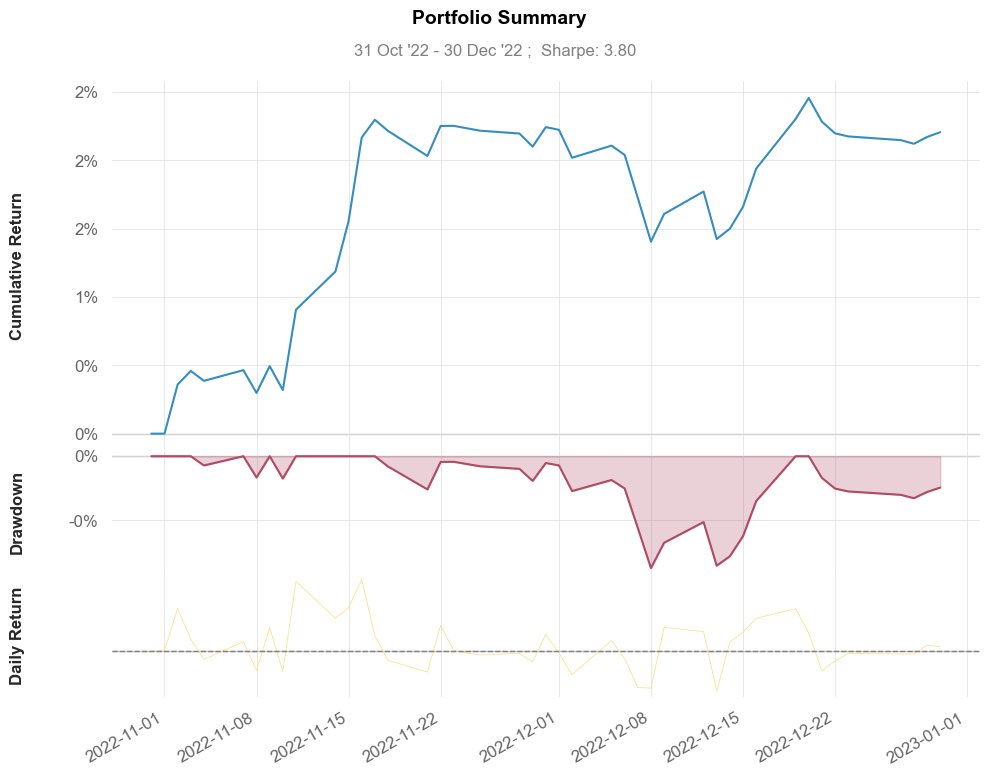

[*********************100%***********************]  1 of 1 completed

FACTORLIB STATS REPORT             
Relative to baseline models:  
Information coefficient (spearman): -0.05350930130313893
+--------------+----------+--------+
|   metric:    | Strategy |  spy   |
+--------------+----------+--------+
| cum. returns |  2.21%   | -0.09% |
|    sharpe    |   3.84   |  0.09  |
|   sortino    |   7.56   |  0.15  |
|     cagr     |  9.77%   | -0.37% |
|  avg rtrns   |  0.05%   | 0.01%  |
| max drawdown |  -0.87%  | -7.18% |
|  volatility  |  3.42%   | 23.59% |
|   win rate   |  53.66%  | 41.46% |
+--------------+----------+--------+


In [21]:
stats = factor_model.wfo(returns,
                         train_interval=pd.DateOffset(years=5), train_freq='M', anchored=False,
                         start_date=datetime(2017, 11, 5), end_date=datetime(2022, 12, 20),
                         candidates=candidates,
                         save_dir=get_experiments_dir(), **kwargs,
                         port_opt=PortOptOptions.MeanVariance)
stats.stats_report()

## Load Model
Now that we have run the model once, it has been saved to save_dir. Now we can load it in again without having to add all the initial factors.

In [20]:
base_model = FactorModel(load_path=Path('experiments/base_model/base_model_0.alpha')).load()
stats = base_model.stats
# base_model_stats = base_model.wfo(returns,
#                          train_interval=pd.DateOffset(years=5), train_freq='M', anchored=False,
#                          start_date=datetime(2017, 11, 5), end_date=datetime(2022, 12, 20),
#                          candidates=candidates,
#                          save_dir=get_experiments_dir(), **kwargs,
#                          port_opt=PortOptOptions.MeanVariance)

FileNotFoundError: [Errno 2] No such file or directory: 'experiments/base_model/base_model_0.alpha'

In [4]:
stats.stats_report()

NameError: name 'stats' is not defined

In [25]:
stats.get_factors()

['RET_01',
 'RET_02',
 'RET_03',
 'RET_04',
 'RET_05',
 'RET_10',
 'RET_20',
 'RET_40',
 'RET_60',
 'RET_120',
 'RET_210',
 'Open',
 'High',
 'Low',
 'Close',
 'Volume',
 'PCAReturn_1',
 'PCAReturn_2',
 'PCAReturn_3',
 'PCAReturn_4',
 'PCAReturn_5',
 'cash_flow',
 'capx_per_share',
 'equity_earnings_per_share',
 'prefer_dvd_coverage',
 'tax_rate',
 'cash_flow_per_share',
 'depreciation_per_share',
 'discontinued_ops_per_share',
 'eps',
 'extraordinary_per_share',
 'extraordinary_discontinued_per_share',
 'interest_expense_per_share',
 'non_operating_inc_per_share',
 'op_income_after_deprec_per_share',
 'op_income_before_deprec_per_share',
 'pretax_income_per_share',
 'rnd_per_share',
 'cogs_to_sales',
 'deprec_to_sales',
 'interest_to_sales',
 'nonop_income_to_sales',
 'rnd_to_sales',
 'sga_to_sales',
 'cash_flow_margin',
 'net_profit_margin',
 'op_profit_after_deprec',
 'op_profit_before_deprec',
 'pretax_profit_margin',
 'gross_assets',
 'net_operating_assets',
 'total_debt',
 'total